딥러닝세션 2차시 과제

In [4]:
import numpy as np # 행렬연산
import matplotlib.pyplot as plt # 시각화

import torch # 파이토치
import torch.nn as nn # 파이토치 모듈
import torch.nn.init as init # 초기화 관련 모듈 
import torch.optim as optim #최적화함수
from torch.utils.data import Dataset, DataLoader, random_split # 데이터셋을 학습에 용이하게 바꿈
import torch.nn.functional as F # 자주 쓰는 함수를 F로 따로 가져옴

batch_size = 1500
learning_rate = 0.01
num_epoch = 20

In [5]:
rawDataset = "log.csv"

class CSVDataset(Dataset):
    def __init__(self, file_path):
        data = np.loadtxt(file_path, delimiter=",", skiprows=1, dtype=np.float32)
        self.x = torch.tensor(data[:, :-1])  # 특성 데이터
        self.y = torch.tensor(data[:, -1])   # 타겟 데이터

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = CSVDataset(rawDataset)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
print(f"Train Dataset 크기: {len(train_dataset)}")
print(f"Test Dataset 크기: {len(test_dataset)}")

Train Dataset 크기: 7997
Test Dataset 크기: 2000


In [7]:
Data, Scores = next(iter(train_loader))

for score in Scores:
    print(score)

tensor(74.5971)
tensor(71.0730)
tensor(66.8733)
tensor(74.1918)
tensor(69.1899)
tensor(67.3384)
tensor(68.3404)
tensor(69.2912)
tensor(68.6631)
tensor(67.2276)
tensor(67.4232)
tensor(71.7577)
tensor(68.3460)
tensor(66.3901)
tensor(74.3927)
tensor(82.1312)
tensor(73.7417)
tensor(68.4395)
tensor(68.1624)
tensor(66.8564)
tensor(79.1068)
tensor(73.4371)
tensor(68.6578)
tensor(70.1429)
tensor(79.3452)
tensor(74.8132)
tensor(72.9753)
tensor(77.1547)
tensor(72.1153)
tensor(70.4368)
tensor(74.9182)
tensor(72.0529)
tensor(67.6444)
tensor(81.9753)
tensor(71.0813)
tensor(68.0184)
tensor(67.5587)
tensor(84.3366)
tensor(69.3700)
tensor(68.3344)
tensor(71.8434)
tensor(71.1276)
tensor(71.4693)
tensor(75.2197)
tensor(65.6298)
tensor(76.3347)
tensor(65.8077)
tensor(70.7118)
tensor(76.8726)
tensor(69.9795)
tensor(66.8683)
tensor(65.8962)
tensor(70.4551)
tensor(71.6014)
tensor(76.2025)
tensor(72.2640)
tensor(68.6844)
tensor(67.2940)
tensor(70.1785)
tensor(67.7684)
tensor(72.3034)
tensor(71.7272)
tensor(7

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # layer 생성
        self.fc1 = nn.Linear(5, 100) # ABCDE가 입력되니까 5
        self.fc2 = nn.Linear(100, 25) # 간단해서 은닉층은 한개로, 10노드
        self.fc3 = nn.Linear(25, 1)
        
        self.dropout = nn.Dropout(0.5) # 연산마다 50% 비율로 랜덤하게 노드 삭제... 나중에
        
        self.batch_norm1 = nn.BatchNorm1d(100) # 1dimension이기 때문에 BatchNorm1d를 사용함.
        self.batch_norm2 = nn.BatchNorm1d(25)
    
    
    def forward(self, x): # 모델의 연산 순서를 정의
    # 1st layer
        x = x.view(-1, 5)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) # activation function
        x = self.dropout(x)
    # 2nd layer
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)
    # 3rd layer
        x = self.fc3(x)
        return x

In [9]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model= MLP()
model.apply(weight_init)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.3)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [10]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (Data, Score) in enumerate(train_loader): # A,B,C,D,E, Score로 이루어진 train set
        optimizer.zero_grad() # 최적화 초기화
        output = model(Data) #  모델에 input을 넣어서 예측값을 구한다
        loss = loss_fn(output, Score) # 손실함수, error 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정
        optimizer.step() # 역전파 진행 및 가중치 업데이트

In [11]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad(): # 모델의 평가 단계이므로 gradient가 업데이트 되지 않도록 함
        for data, score in test_loader:
            output = model(data)
            test_loss += loss_fn(output, score).item() # loss 누적
            
            correct += output.eq(score.view_as(output)).sum().item() # 예측 몇개 맞음?
    
    test_loss /= len(test_loader.dataset) # loss 평균값 계산
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
# 결과를 저장할 리스트
epoch_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(1, num_epoch + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    epoch_list.append(epoch)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    
    print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} ".format(
        epoch, test_loss, test_accuracy
    ))

c:\Users\i-dle\anaconda3\envs\wetie_dl\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1500])) that is different to the input size (torch.Size([1500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\i-dle\anaconda3\envs\wetie_dl\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([497])) that is different to the input size (torch.Size([497, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\i-dle\anaconda3\envs\wetie_dl\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 1])). This will likely lead to incorrect results due to broadcasting. Please

[EPOCH: 1], 	Test Loss: 0.3550, 	Test Accuracy: 0.00 
[EPOCH: 2], 	Test Loss: 0.0346, 	Test Accuracy: 0.00 
[EPOCH: 3], 	Test Loss: 0.0477, 	Test Accuracy: 0.00 
[EPOCH: 4], 	Test Loss: 0.0496, 	Test Accuracy: 0.00 
[EPOCH: 5], 	Test Loss: 0.0460, 	Test Accuracy: 0.00 
[EPOCH: 6], 	Test Loss: 0.0794, 	Test Accuracy: 0.00 
[EPOCH: 7], 	Test Loss: 0.0524, 	Test Accuracy: 0.00 
[EPOCH: 8], 	Test Loss: 0.0202, 	Test Accuracy: 0.00 
[EPOCH: 9], 	Test Loss: 0.0186, 	Test Accuracy: 0.00 
[EPOCH: 10], 	Test Loss: 0.0183, 	Test Accuracy: 0.00 
[EPOCH: 11], 	Test Loss: 0.0288, 	Test Accuracy: 0.00 
[EPOCH: 12], 	Test Loss: 0.0237, 	Test Accuracy: 0.00 
[EPOCH: 13], 	Test Loss: 0.0205, 	Test Accuracy: 0.00 
[EPOCH: 14], 	Test Loss: 0.0507, 	Test Accuracy: 0.00 
[EPOCH: 15], 	Test Loss: 0.0610, 	Test Accuracy: 0.00 
[EPOCH: 16], 	Test Loss: 0.0718, 	Test Accuracy: 0.00 
[EPOCH: 17], 	Test Loss: 0.0259, 	Test Accuracy: 0.00 
[EPOCH: 18], 	Test Loss: 0.0272, 	Test Accuracy: 0.00 
[EPOCH: 19], 	Test 

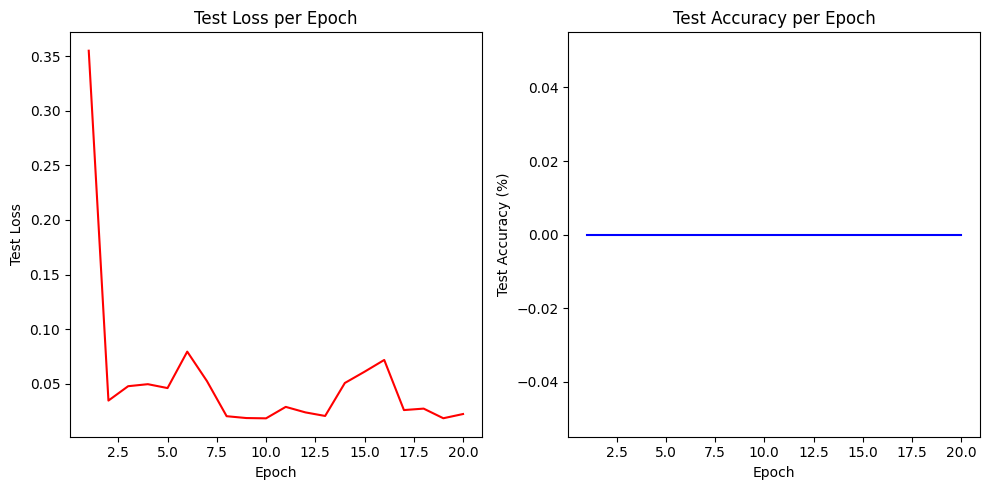

In [13]:
# 시각화
plt.figure(figsize=(10, 5))

# Test Loss
plt.subplot(1, 2, 1)
plt.plot(epoch_list, test_loss_list, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss per Epoch')

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy per Epoch')

plt.tight_layout()
plt.show()